### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar100 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 2 --max_classes_per_drift 0

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Functions

In [3]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [4]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [37]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(cumulative_averages, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="upper right")
    plt.show()

In [38]:
def plot_cumulative_subplots(title, accuracy_arrays, subtitles, plot_filename):
    assert len(accuracy_arrays) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    labels = ["Without Drift", "With Drift", "Drift with Full Re-learning", "Drift with Buffer Resampling"]

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    fig, axes = plt.subplots(1, len(accuracy_arrays) // 4, figsize=(12, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=14)
            axes[i].legend(prop={"size": 8}, loc="upper right")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 5)))

    fig.supxlabel("Task Trained On", fontsize=14)
    fig.supylabel("Accuracy (%)", fontsize=14)
    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

In [39]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

CIFAR100 10 Tasks, 10 Classes Per Task

# ER

## Buffer 500

### Without Drift

In [40]:
er_500_accuracy_array_without_drift = read_results(
    "./logs/01-21-25-21-18-05-seq-cifar100-er-buf-500-drift-6-n-4-adaptation-0.json"
)
# 9.66, 9.78, 9.87
# 9.769999999999998 ± 0.08602325267042588
# plot_results(
#     er_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8

In [41]:
er_500_accuracy_array_with_drift = read_results(
    "./logs/01-21-25-23-24-50-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-0.json"
)
# 8.62, 8.70, 8.79
# 8.703333333333333 ± 0.0694422221866655
# plot_results(
#     er_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning

In [42]:
er_500_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-22-25-00-09-31-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-1.json"
)
# 16.18, 16.31, 16.43
# 16.306666666666665 ± 0.10208928554075702
# plot_results(
#     er_500_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling

In [43]:
er_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-22-25-02-07-26-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-2.json"
)
# 11.67, 11.90, 12.37
# 11.979999999999999 ± 0.29131884021921145
# plot_results(
#     er_500_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling",
# )

### Cumulative Plots

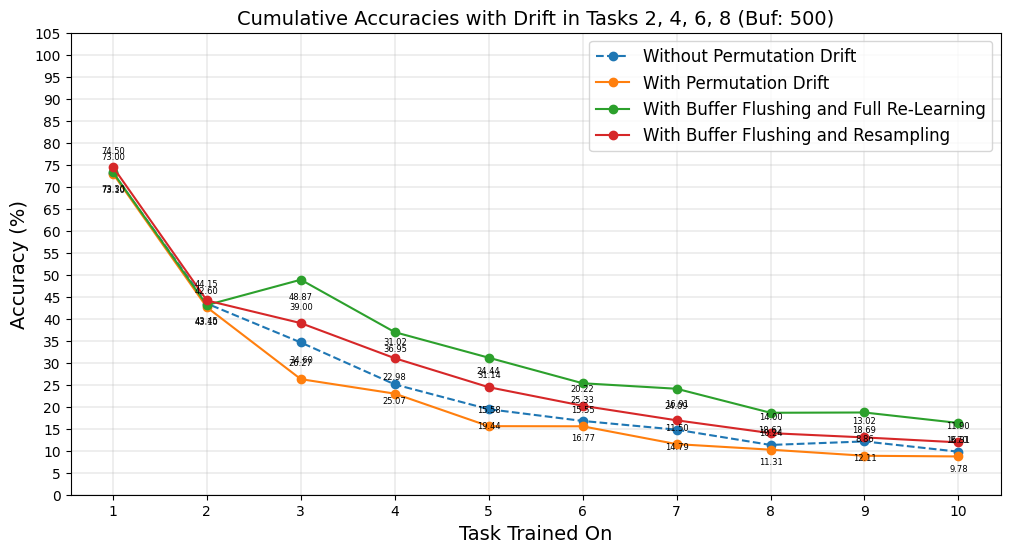

In [44]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4, 6, 8 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [67]:
er_5000_accuracy_array_without_drift = read_results(
    "./logs/01-22-25-03-53-38-seq-cifar100-er-buf-5000-drift-6-n-4-adaptation-0.json"
)
# 22.44, 22.80, 23.39
# 22.876666666666665 ± 0.39160637833870293
# plot_results(
#     er_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8

In [75]:
er_5000_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-05-12-56-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-0.json"
)
# 10.77, 11.01, 11.10
# 10.96 ± 0.13928388277184126
# plot_results(
#     er_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning

In [84]:
er_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-22-25-06-26-42-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-1.json"
)
# 25.37, 25.40, 26.01
# 25.593333333333334 ± 0.2948822740612871
# plot_results(
#     er_5000_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling

In [92]:
er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-22-25-09-03-09-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-2.json"
)
# 23.72, 23.78, 23.82
# 23.77333333333333 ± 0.041096093353127174
# plot_results(
#     er_5000_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling",
# )

### Cumulative Plots

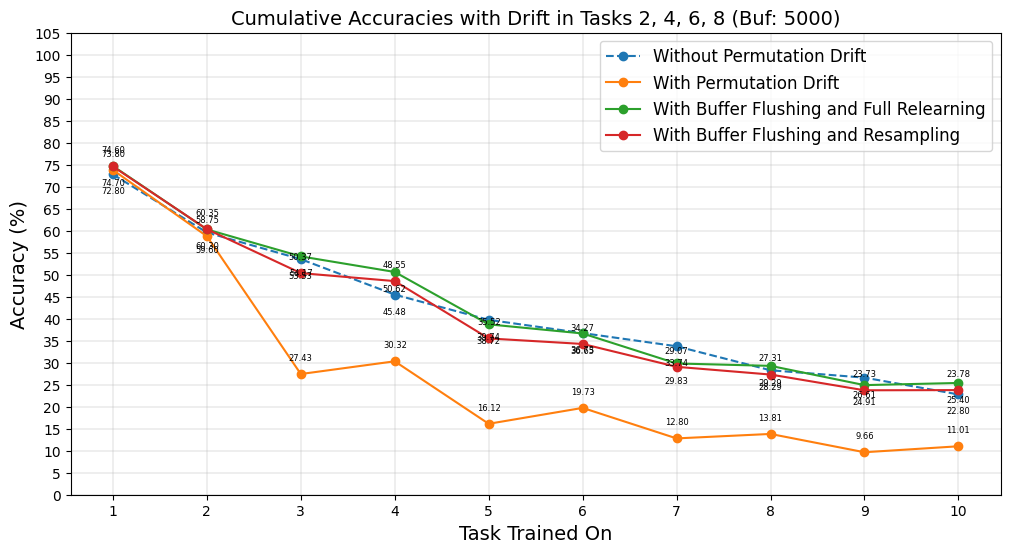

In [93]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4, 6, 8 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Without Drift

In [45]:
er_ace_500_accuracy_array_without_drift = read_results(
    "./logs/01-21-25-23-30-03-seq-cifar100-er_ace-buf-500-drift-6-n-4-adaptation-0.json"
)
# 20.88, 21.82, 22.67
# 21.790000000000003 ± 0.7310722718491437
# plot_results(
#     er_ace_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8

In [46]:
er_ace_500_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-00-12-08-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-0.json"
)
# 6.76, 6.86, 7.54
# 7.053333333333334 ± 0.3465384378231207
# plot_results(
#     er_ace_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning

In [47]:
er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-22-25-05-18-59-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-1.json"
)
# 17.43, 17.62, 17.95
# 17.666666666666668 ± 0.21483844059095994
# plot_results(
#     er_ace_500_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling

In [48]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-22-25-07-36-40-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-2.json"
)
# 11.44, 12.29,  12.30
# 12.01 ± 0.4030715403829286
# plot_results(
#     er_ace_500_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling",
# )

### Cumulative Plots

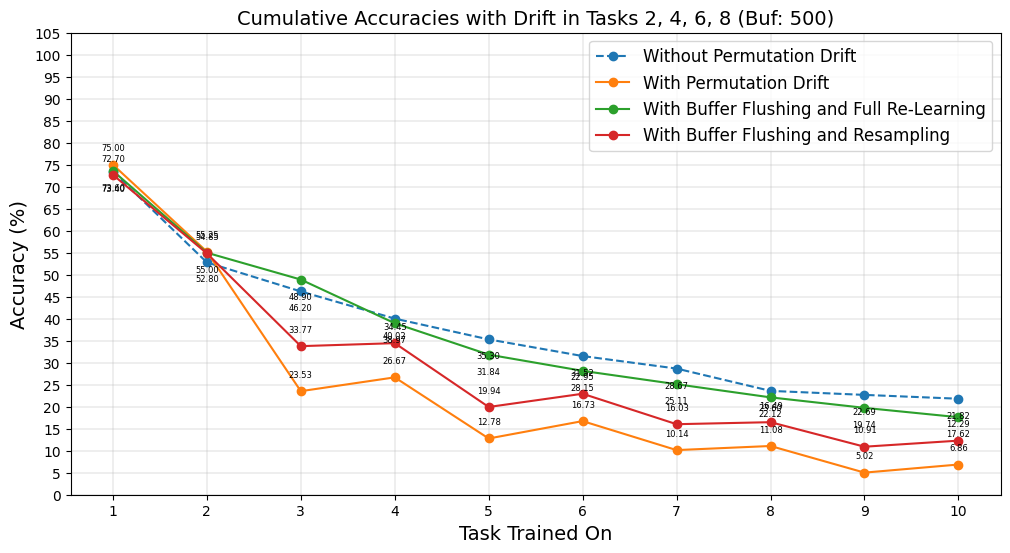

In [49]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4, 6, 8 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [101]:
er_ace_5000_accuracy_array_without_drift = read_results(
    "./logs/01-22-25-09-04-50-seq-cifar100-er_ace-buf-5000-drift-6-n-4-adaptation-0.json"
)
# 31.88, 32.03, 32.40
# 32.10333333333333 ± 0.21853044537444974
# plot_results(
#     er_ace_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8

In [109]:
er_ace_5000_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-11-27-54-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-0.json"
)
# 9.66, 9.75, 9.99
# 9.799999999999999 ± 0.13928388277184126
# plot_results(
#     er_ace_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning

In [120]:
er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-22-25-13-31-06-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-1.json"
)
# 25.24, 25.80, 25.89
# 25.643333333333334 ± 0.28755675768253036
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling

In [128]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-22-25-18-33-45-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-2.json"
)
# 21.94, 22.48, 22.78
# 22.400000000000002 ± 0.3475629439396552
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling",
# )

### Cumulative Plots

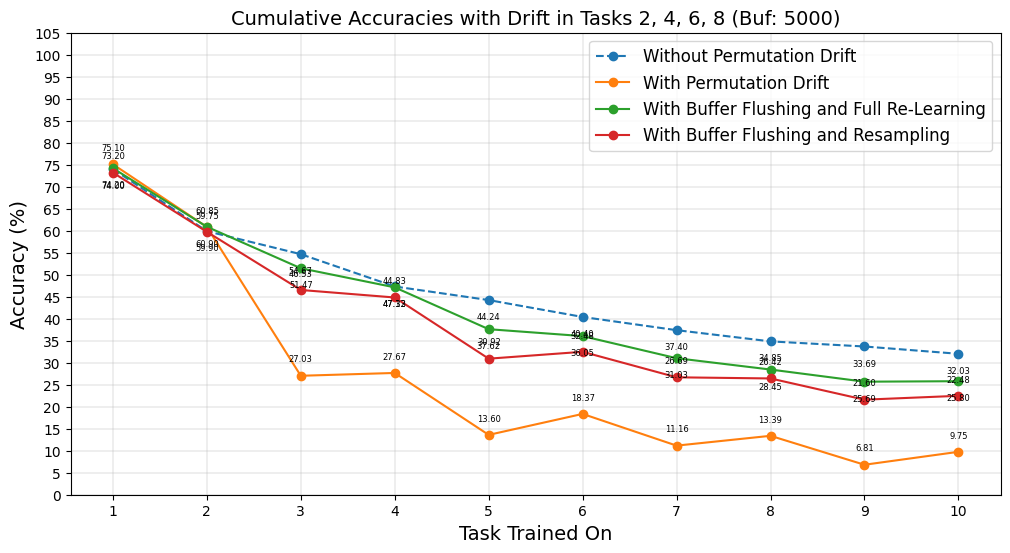

In [129]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4, 6, 8 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Without Drift

In [50]:
derpp_500_accuracy_array_without_drift = read_results(
    "./logs/01-21-25-22-50-54-seq-cifar100-derpp-buf-500-drift-6-n-4-adaptation-0.json"
)
# 11.67, 11.76, 11.99
# 11.806666666666667 ± 0.13474255287605172
# plot_results(
#     derpp_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8

In [51]:
derpp_500_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-02-32-43-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-0.json"
)
# 8.85, 8.90, 8.94
# 8.896666666666667 ± 0.036817870057290834
# plot_results(
#     derpp_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning

In [52]:
derpp_500_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-22-25-06-54-49-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-1.json"
)
# 17.05, 17.05, 17.46
# 17.186666666666667 ± 0.19327585352432305
# plot_results(
#     derpp_500_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling

In [54]:
derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-22-25-14-40-25-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-2.json"
)
# 11.42, 11.75, 11.85
# 11.673333333333334 ± 0.18372685039360884
# plot_results(
#     derpp_500_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling",
# )

### Cumulative Plots

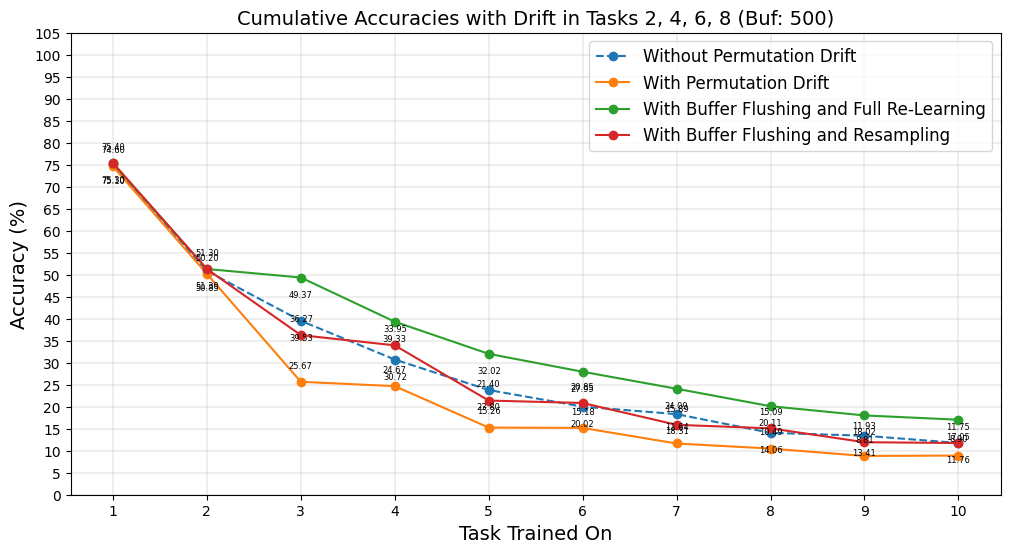

In [55]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4, 6, 8 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [140]:
derpp_5000_accuracy_array_without_drift = read_results(
    "./logs/01-22-25-15-56-23-seq-cifar100-derpp-buf-5000-drift-6-n-4-adaptation-0.json"
)
# 30.63, 31.30, 32.41
# 31.44666666666667 ± 0.734045109119474
# plot_results(
#     derpp_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8

In [147]:
derpp_5000_accuracy_array_with_drift = read_results(
    "./logs/01-22-25-21-31-28-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-0.json"
)
# 10.35, 10.39, 10.54
# 10.426666666666668 ± 0.08178562764256828
# plot_results(
#     derpp_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8",
# )

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning

In [ ]:
values = []
f"{np.mean(values)} ± {np.std(values)}"

In [97]:
derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
)
# 
# 
plot_results(
    derpp_5000_accuracy_array_with_drift_full_relearning,
    title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Relearning",
)

### With Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling

In [98]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
)
# 
# 
plot_results(
    derpp_5000_accuracy_array_with_drift_buffer_resampling,
    title="Accuracy with Permutation Drift in Tasks 2, 4, 6, 8 and Adaptive Buffer Resampling",
)

### Cumulative Plots

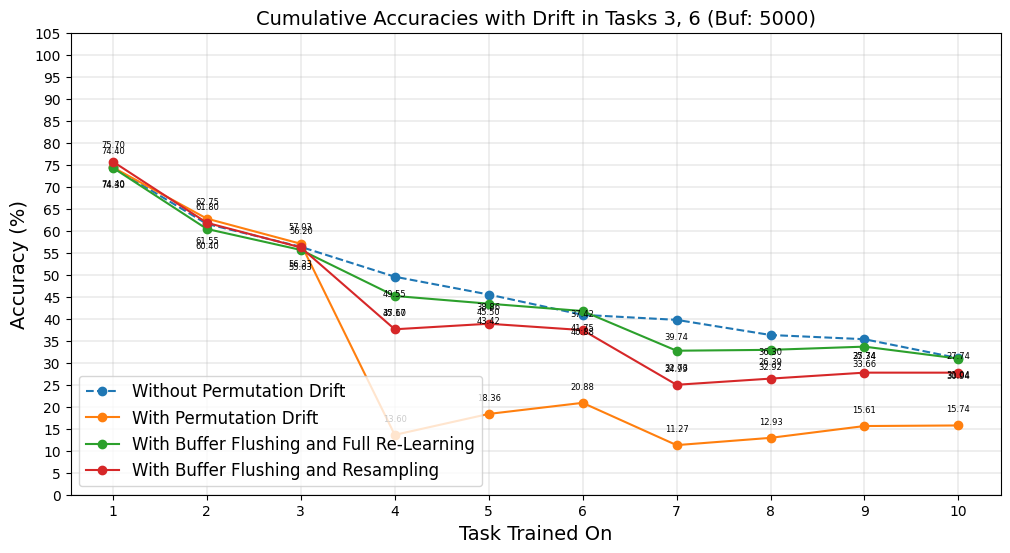

In [99]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4, 6, 8 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

In [ ]:
values = []
f"{np.mean(values)} ± {np.std(values)}"

## Buffer 500

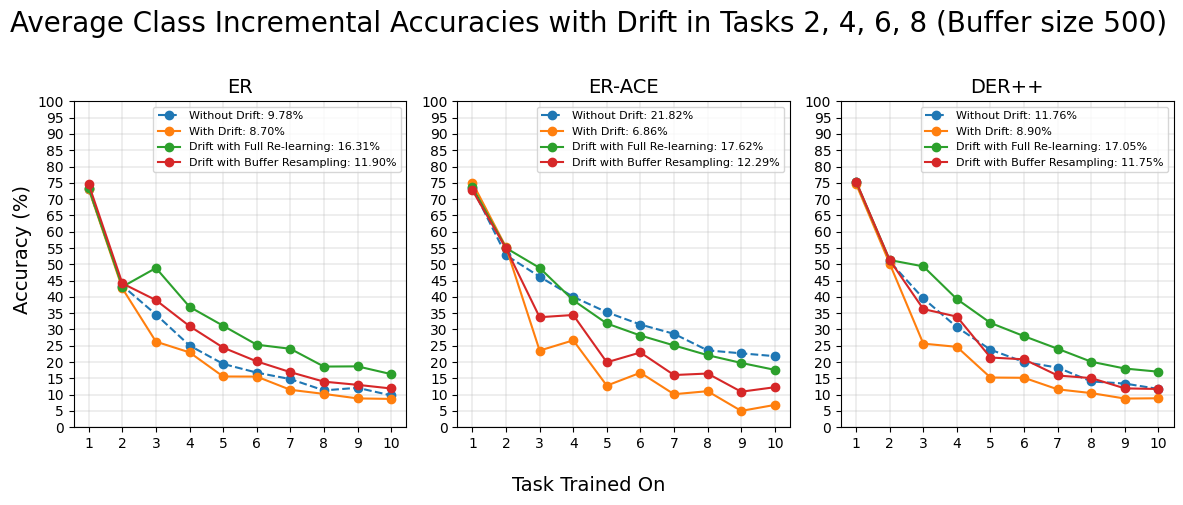

In [56]:
plot_cumulative_subplots(
    "Average Class Incremental Accuracies with Drift in Tasks 2, 4, 6, 8 (Buffer size 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR100_Buff_500_n_4.pdf",
)

## Buffer 5000

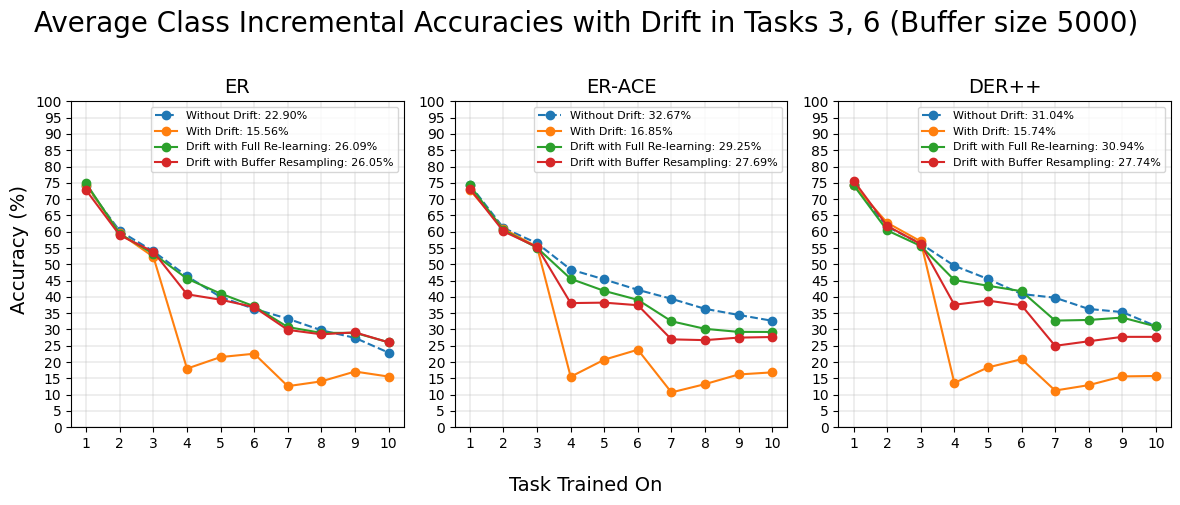

In [100]:
plot_cumulative_subplots(
    "Average Class Incremental Accuracies with Drift in Tasks 2, 4, 6, 8 (Buffer size 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR100_Buff_5000_n_4.pdf",
)